In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from mnist import MNIST

## Loading and Preprocessing data

In [2]:
mndata = MNIST("datasets/mnist")

# Training split
train_images, train_labels = mndata.load_training()

# Test split
test_images, test_labels = mndata.load_testing()

In [3]:
mnist_img_size = (28, 28)
mnist_classes = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Converting to numpy arrays, normalizing
train_images = np.array(train_images).reshape(-1, mnist_img_size[0], mnist_img_size[1]) / 255.0
train_labels = np.array(train_labels)

test_images = np.array(test_images).reshape(-1, mnist_img_size[0], mnist_img_size[1]) / 255.0
test_labels = np.array(test_labels)

In [1]:
train_images.shape

NameError: name 'train_images' is not defined

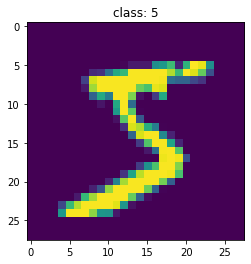

In [5]:
# Sample output
idx = 0
plt.imshow(train_images[idx, :, :])
plt.title(f"class: {train_labels[idx]}")
plt.show()

## Classification Model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [ ]:
pred = model(train_images[:1]).numpy()
print(pred)

In [ ]:
tf.nn.softmax(pred).numpy()

In [ ]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(train_images, train_labels, epochs=1)

In [ ]:
model.evaluate(test_images, test_labels, verbose=2)

## AutoEncoder

In [ ]:
from tensorflow.keras import layers

In [ ]:
# Custon Layer for VAE
class Sampling(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape= (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
encoder_input = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, strides= 2, activation= "relu", padding= "same")(encoder_input)
x = layers.Conv2D(64, 3, strides= 2, activation= "relu", padding= "same")(x)
x = layers.Flatten()(x)

# Latent Space
latent_dim = 2
z_mean = layers.Dense(latent_dim, name= "z_mean")(x)
z_log_var = layers.Dense(latent_dim, name= "z_log_var")(x)

z = Sampling()(z_mean, z_log_var)

encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var, z])

In [ ]:
def kl_divergence(z_mean, z_log_var):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return tf.reduce_mean(tf.reduce_sum(kl_loss, axis= 1))

In [ ]:
# Decoder
latent_input = tf.keras.Input(shape=(latent_dim, ))
y = layers.Dense( 7*7*64, activation="relu")(latent_input)
y = layers.Reshape((7, 7, 64))(y)
y = layers.Conv2DTranspose(32, 3, strides= 2, activation= "relu", padding= "same")(y)
y = layers.Conv2DTranspose(1, 3, strides= 2, activation= "sigmoid", padding= "same")(y)

decoder = tf.keras.Model(latent_input, y)

z_mean, z_log_var, z = encoder(encoder_input)
decoder_output = decoder(z)

vae = tf.keras.Model(encoder_input, decoder_output)

In [ ]:
vae.summary()

In [ ]:
def reconstruction_loss(real, reconstruction):
    return tf.reduce_mean(tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(real, reconstruction),
        axis= (1,2)
    ))

In [ ]:
vae.compile(optimizer = tf.keras.optimizers.Adam(),
            loss= reconstruction_loss,
            metrics= ["mse"])

In [ ]:
vae.fit(np.expand_dims(train_images, axis=-1), np.expand_dims(train_images, axis=-1), epochs= 5)

## Model Subclassing

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = 2
        self.encoder = self.create_encoder(latent_dim = self.latent_dim)
        self.decoder = self.create_decoder(latent_dim = self.latent_dim)
    
    @staticmethod
    def create_encoder(latent_dim):
        # Encoder
        encoder_input = tf.keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, 3, strides= 2, activation= "relu", padding= "same")(encoder_input)
        x = layers.Conv2D(64, 3, strides= 2, activation= "relu", padding= "same")(x)
        x = layers.Flatten()(x)

        # Latent Space
        z_mean = layers.Dense(latent_dim, name= "z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name= "z_log_var")(x)

        z = Sampling()(z_mean, z_log_var)

        encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var, z])

        return encoder

    @staticmethod
    def create_decoder(latent_dim):
        # Decoder
        latent_input = tf.keras.Input(shape=(latent_dim,))
        y = layers.Dense( 7*7*64, activation="relu")(latent_input)
        y = layers.Reshape((7, 7, 64))(y)
        y = layers.Conv2DTranspose(32, 3, strides= 2, activation= "relu", padding= "same")(y)
        y = layers.Conv2DTranspose(1, 3, strides= 2, activation= "sigmoid", padding= "same")(y)

        decoder = tf.keras.Model(latent_input, y)

        return decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            kl_loss = kl_divergence(z_mean, z_log_var)
            reco_loss = reconstruction_loss(data, reconstruction)
            total_loss = reco_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"total_loss": total_loss}

## Distributed Strategy

In [ ]:
try:
    # detect TPU (8 cores or more)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver().connect()
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    # detect one or multiple GPUs
    strategy = tf.distribute.MirroredStrategy()

In [ ]:
with strategy.scope():
    # encoder = VAE.create_encoder()
    # decoder = VAE.create_decoder()
    vae = VAE()
    vae.compile(optimizer = tf.keras.optimizers.Adam())

In [ ]:
vae.fit(train_images, epochs= 10)

In [ ]:
vae.build(input_shape=(28,28,1))

## Custom Layers and Models

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [7]:
x_train = np.expand_dims(train_images.reshape(train_images.shape[0], -1), axis = -1)

In [8]:
x_train.shape

(60000, 784, 1)

In [ ]:
# Custon Layer for VAE
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape= (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
original_dim = 784
intermediate_dim = 64
latent_dim = 32

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

# Train.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=1, batch_size=64)

In [ ]:
# vae.summary()

In [ ]:
plot_model(vae, show_shapes= True, expand_nested= True)

## Sub classing

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape= (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [11]:
class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)

In [39]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed
    def build_graph(self):
        """Used for model.summary() and plot_model()"""
        x = tf.keras.Input(shape=(self.original_dim))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [40]:
original_dim = 784
vae = VariationalAutoEncoder(original_dim, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

In [41]:
x_train = train_images.reshape(train_images.shape[0], -1)
print(x_train.shape)

(60000, 784)


In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

In [43]:
epochs = 1

# Iterate over epochs.
for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            print("step %d: mean loss = %.4f" % (step, loss_metric.result()))

Start of epoch 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

step 0: mean loss = 0.3100
step 100: mean loss = 0.1247
step 200: mean loss = 0.0988
step 300: mean loss = 0.0889
step 400: mean loss = 0.0840
step 500: mean loss = 0.0807
step 600: mean loss = 0.0786
step 700: mean loss = 0.0770
step 800: mean loss = 0.0759
step 900: mean loss = 0.0749


In [29]:
vae = VariationalAutoEncoder(784, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=2, batch_size=64)

Epoch 1/2
938/938 [==============================] - 3s 3ms/step - loss: 0.0749
Epoch 2/2
938/938 [==============================] - 3s 3ms/step - loss: 0.0676


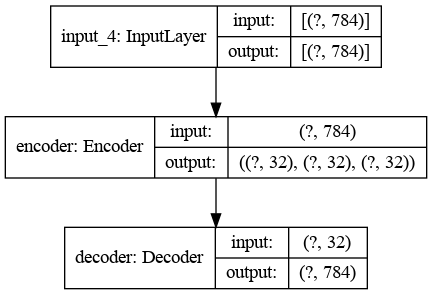

In [45]:
plot_model(vae.build_graph(), show_shapes= True, expand_nested= True)

In [44]:
vae.build_graph().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Encoder)            ((None, 32), (None, 32),  54400     
_________________________________________________________________
decoder (Decoder)            (None, 784)               53072     
Total params: 107,472
Trainable params: 107,472
Non-trainable params: 0
_________________________________________________________________
